In [1]:
import pandas as pd
import numpy as np
import json
import os

JSON_FILE_PATH = 'user-wallet-transactions.json'
OUTPUT_SCORES_PATH = 'wallet_scores.csv'

if not os.path.exists(JSON_FILE_PATH):
    raise FileNotFoundError(f"File not found at: {JSON_FILE_PATH}. Please upload the file to the Colab files section.")

def load_transactions(file_path):
    print("Loading data...")
    try:
        df = pd.read_json(file_path, lines=False)

        action_data_df = pd.json_normalize(df['actionData'])

        df = pd.concat([df.drop('actionData', axis=1), action_data_df], axis=1)

        df = df.drop(columns=['_id', 'logId', 'poolId', '__v', 'createdAt', 'updatedAt', 'network', 'protocol', 'userId'])

        print("Data loaded and preprocessed successfully.")
        return df

    except Exception as e:
        print(f"Error loading or preprocessing data: {e}")
        raise

def engineer_features(df):
    print("Engineering features...")

    df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
    df['assetPriceUSD'] = pd.to_numeric(df['assetPriceUSD'], errors='coerce')

    df['value_usd'] = df['amount'] * df['assetPriceUSD']
    df['is_liquidated_borrower'] = df['action'] == 'liquidationCall'

    wallet_features = df.groupby('userWallet').agg(
        total_tx_count=('txHash', 'count'),
        first_tx_timestamp=('timestamp', 'min'),
        last_tx_timestamp=('timestamp', 'max'),
        unique_assets_count=('assetSymbol', 'nunique'),
        num_deposits=('action', lambda x: (x == 'deposit').sum()),
        total_deposit_usd=('value_usd', lambda x: x[df['action'] == 'deposit'].sum()),
        num_borrows=('action', lambda x: (x == 'borrow').sum()),
        total_borrow_usd=('value_usd', lambda x: x[df['action'] == 'borrow'].sum()),
        num_repays=('action', lambda x: (x == 'repay').sum()),
        total_repay_usd=('value_usd', lambda x: x[df['action'] == 'repay'].sum()),
        num_liquidations_as_borrower=('is_liquidated_borrower', 'sum')
    )
    wallet_features['first_tx_timestamp'] = pd.to_datetime(wallet_features['first_tx_timestamp'], unit='s')
    wallet_features['last_tx_timestamp'] = pd.to_datetime(wallet_features['last_tx_timestamp'], unit='s')

    wallet_age_timedelta = wallet_features['last_tx_timestamp'] - wallet_features['first_tx_timestamp']

    wallet_features['wallet_age_days'] = wallet_age_timedelta.dt.total_seconds() / (60 * 60 * 24)

    wallet_features['avg_tx_per_day'] = wallet_features['total_tx_count'] / (wallet_features['wallet_age_days'] + 1e-6)

    wallet_features['repayment_ratio_usd'] = wallet_features.apply(
        lambda row: row['total_repay_usd'] / row['total_borrow_usd'] if row['total_borrow_usd'] > 0 else 1.0,
        axis=1
    )

    print("Feature engineering complete.")
    return wallet_features.reset_index()

def calculate_credit_score(features_df):
    print("Calculating credit scores...")

    scores = []
    for _, row in features_df.iterrows():
        score = 500

        score += np.log1p(row['wallet_age_days']) * 10
        score += np.log1p(row['total_deposit_usd']) * 5

        capped_repayment_ratio = min(row['repayment_ratio_usd'], 1.0)
        score += capped_repayment_ratio * 150

        score -= row['num_liquidations_as_borrower'] * 300

        borrow_to_deposit_ratio = row['total_borrow_usd'] / (row['total_deposit_usd'] + 1e-6)
        score -= min(borrow_to_deposit_ratio, 2.0) * 50

        final_score = score
        final_score = max(0, min(1000, final_score))

        scores.append(final_score)

    features_df['credit_score'] = scores
    print("Credit score calculation complete.")
    return features_df[['userWallet', 'credit_score']]

def main():
    print("Starting Aave V2 Credit Scoring pipeline...")

    df = load_transactions(JSON_FILE_PATH)

    wallet_features_df = engineer_features(df)

    final_scores_df = calculate_credit_score(wallet_features_df)

    print(f"Saving final scores to {OUTPUT_SCORES_PATH}...")
    final_scores_df.to_csv(OUTPUT_SCORES_PATH, index=False)
    print("Scoring process finished. Output saved.")
    print("Please download the 'wallet_scores.csv' file from the Colab files section before your session ends.")

if __name__ == "__main__":
    main()

Starting Aave V2 Credit Scoring pipeline...
Loading data...
Data loaded and preprocessed successfully.
Engineering features...
Feature engineering complete.
Calculating credit scores...
Credit score calculation complete.
Saving final scores to wallet_scores.csv...
Scoring process finished. Output saved.
Please download the 'wallet_scores.csv' file from the Colab files section before your session ends.


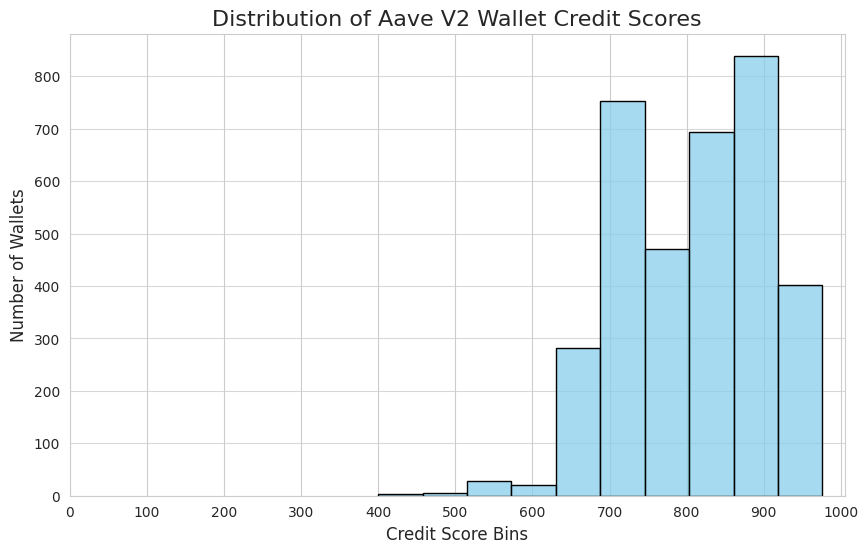

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

final_scores_df = pd.read_csv('wallet_scores.csv')

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))

sns.histplot(final_scores_df['credit_score'], bins=10, kde=False, color='skyblue', edgecolor='black')

plt.title('Distribution of Aave V2 Wallet Credit Scores', fontsize=16)
plt.xlabel('Credit Score Bins', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.xticks(np.arange(0, 1001, 100))
plt.grid(axis='y', alpha=0.75)

plt.savefig('score_distribution.png')

plt.show()